# __Movie Sentiment Analysis__

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils

from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor


warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dambz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dambz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dambz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [2]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [5]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [6]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 
               'overview', 'tagline', 'production_countries', 'runtime', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,adult,budget,genres,imdb_id,production_companies,release_date,revenue,title,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [7]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [8]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [9]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [10]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,adult,budget,genres,imdb_id,production_companies,release_date,revenue,title,cast,crew,movie,genre
0,False,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,False,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,False,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,False,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,False,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [11]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw1133942,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8.0,Good follow up that answers all the questions,24-Jul-05,0,"After seeing Tarantino's Kill Bill Vol: 1, I g...","['0', '1']"
1,rw1133959,lost-in-limbo,Feardotcom (2002),3.0,"""I couldn't make much sense of it myself"". Too...",24-Jul-05,0,There's a Website called FearDotCom and anyone...,"['1', '4']"
2,rw1133985,NateManD,Persona (1966),10.0,Persona gives me all the reasons to love art-h...,24-Jul-05,0,"Long before ""Muholland Drive"" there was anothe...","['9', '23']"
3,rw1133999,CAMACHO-4,War of the Worlds (2005),3.0,A disappointing film from the team that you Mi...,24-Jul-05,0,Spielberg said this film is based on the H.G. ...,"['9', '14']"
4,rw1134010,CAMACHO-4,Mr. & Mrs. Smith (2005),6.0,A fun action movie with great chemistry,24-Jul-05,0,"Director Doug Liman, who's gotten famous for m...","['1', '3']"


In [12]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,112896,Dracula: Dead and Loving It (1995),Comedy;Fantasy;Horror,rw1134355,dunmore_ego,2.0,Frightfully Fangless,22-Jul-05,0,"When a ""serious"" movie is pitifully appalling,...","['8', '18']"
1,112641,Casino (1995),Crime;Drama,rw1131938,MichaelMargetis,9.0,"""Running a casino is like robbing a bank with ...",21-Jul-05,1,"Unfortunately, many people have slanted view t...","['0', '1']"
2,112641,Casino (1995),Crime;Drama,rw1143011,bkoganbing,10.0,How Others See Us,05-Aug-05,0,Casino is my favorite movie of the last decade...,"['14', '22']"
3,113101,Four Rooms (1995),Comedy,rw1143887,MovieAddict2016,7.0,"Two rooms are horrible, two are very good...",06-Aug-05,0,I made a blind buy on this one. Why? I like Ta...,"['1', '5']"
4,112281,Ace Ventura: When Nature Calls (1995),Adventure;Comedy;Crime,rw1131123,Punk19,NaN,Jimbo's back,20-Jul-05,1,That fun loving Ace Ventura(Jim Carrey)is bein...,"['0', '2']"


In [13]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful', 'rating']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,review_summary,review_date,review_detail
0,112896,Frightfully Fangless,22-Jul-05,"When a ""serious"" movie is pitifully appalling,..."
1,112641,"""Running a casino is like robbing a bank with ...",21-Jul-05,"Unfortunately, many people have slanted view t..."
2,112641,How Others See Us,05-Aug-05,Casino is my favorite movie of the last decade...
3,113101,"Two rooms are horrible, two are very good...",06-Aug-05,I made a blind buy on this one. Why? I like Ta...
4,112281,Jimbo's back,20-Jul-05,That fun loving Ace Ventura(Jim Carrey)is bein...


## Exploratory Data Analysis

Check and resolve duplicate records

In [14]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [15]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 1024
Record count after removing duplicates  => 1024


Check and resolve missing values for `movie metadata`

In [16]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

adult                   3
budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [17]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,adult,budget,genres,imdb_id,production_companies,release_date,revenue,title,cast,crew,movie,genre
2780,NaN,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [18]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 4068 non-null   object 
 1   budget                4068 non-null   float64
 2   genres                4068 non-null   object 
 3   imdb_id               4068 non-null   int64  
 4   production_companies  4068 non-null   object 
 5   release_date          4068 non-null   object 
 6   revenue               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   cast                  4068 non-null   object 
 9   crew                  4068 non-null   object 
 10  movie                 4068 non-null   object 
 11  genre                 4068 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 413.2+ KB


Check and resolve missing values for `movie reviews`

In [19]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id           0
review_summary    0
review_date       0
review_detail     0
dtype: int64

In [20]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024 entries, 0 to 1023
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imdb_id         1024 non-null   int64 
 1   review_summary  1024 non-null   object
 2   review_date     1024 non-null   object
 3   review_detail   1024 non-null   object
dtypes: int64(1), object(3)
memory usage: 40.0+ KB


__Data Wrangling:__ 

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [21]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'movie', 'release_year', 'genre', 'adult', 'budget', 'revenue', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,movie,release_year,genre,adult,budget,revenue,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,False,30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,False,65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,False,60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,False,58000000.0,0.0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,False,35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [22]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [23]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)

movie_reviews_df.head(5)

,imdb_id,review_summary,review_detail,review_year
0,112896,Frightfully Fangless,"When a ""serious"" movie is pitifully appalling,...",2005
1,112641,"""Running a casino is like robbing a bank with ...","Unfortunately, many people have slanted view t...",2005
2,112641,How Others See Us,Casino is my favorite movie of the last decade...,2005
3,113101,"Two rooms are horrible, two are very good...",I made a blind buy on this one. Why? I like Ta...,2005
4,112281,Jimbo's back,That fun loving Ace Ventura(Jim Carrey)is bein...,2005


__For Text Pre-processing:__ 
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [24]:
emoji_dict = tp.get_emojis()
slang_word_dict = tp.webscrape_slang_words()

def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)

        # Replace non-ascii characters as there are Python libraries limiting this feature
        text = tp.replace_nonascii_characters(text)

        # Replace emojis with English word/s
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(initial_text_preprocessing)
movie_reviews_df[['review_summary', 'review_detail']]

,review_summary,review_detail
0,Frightfully Fangless,"When a ""serious"" movie is pitifully appalling,..."
1,"""Running a casino is like robbing a bank with ...","Unfortunately, many people have slanted view t..."
2,How Others See Us,Casino is my favorite movie of the last decade...
3,"Two rooms are horrible, two are very good...",I made a blind buy on this one. Why? I like Ta...
4,Jimbo's back,That fun loving Ace Ventura(Jim Carrey)is bein...
...,...,...
1019,Not for the claustrophobic,From the maker of Dog Soldiers this film share...
1020,He is searching for her. Is she ready?,"A thousand years ago, the Leprechaun left a bl..."
1021,The femme fatal meets her match.,Truly one of the most sinister of RKO's hardco...
1022,"Wonderful, deliberately bad monster movie","As the back cover of a DVD of it points out, t..."


In [25]:
#tp.lemmatize_word('nlp program test')
#tp.lemmatize_word_treebank()

__Lemmatization Program using Treebank Tag__

In [26]:
from nltk.corpus import wordnet
from nltk import pos_tag
#from nltk.tokenize import word_tokenize

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK position tags
def get_wordnet_pos(treebank_tag):
    """
    Return the WordNet POS tag from the Penn Treebank tag
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no matching POS is found

# Create a function to process the sentences
def process_sentence(sentence):
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)
    lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_sentence)
    return lemmatized_sentence

# Apply the processing function to the 'review_summary' column of the DataFrame
movie_reviews_df['lemmatized_review_summary'] = movie_reviews_df['review_summary'].apply(process_sentence)

# Apply the processing function to the 'review_detail' column
movie_reviews_df['lemmatized_review_detail'] = movie_reviews_df['review_detail'].apply(process_sentence)

# Display the comparison between the top 5 original review summary and their lemmatized versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nLemmatized Review Summary:")
    print(movie_reviews_df['lemmatized_review_summary'][i])
    print("="*50)

# Display the comparison between the top 5 original review details and their lemmatized versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nLemmatized Review Details:")
    print(movie_reviews_df['lemmatized_review_detail'][i])
    print("="*50)

Original Review Summary:
Frightfully Fangless

Lemmatized Review Summary:
Frightfully Fangless
Original Review Summary:
"Running a casino is like robbing a bank with no cops around. For guys like me, Las Vegas washes away your sins. It is like a morality car wash." - Sam 'Ace' Rothstein

Lemmatized Review Summary:
`` Running a casino be like rob a bank with no cop around . For guy like me , Las Vegas wash away your sin . It be like a morality car wash. '' - Sam 'Ace ' Rothstein
Original Review Summary:
How Others See Us

Lemmatized Review Summary:
How Others See Us
Original Review Summary:
Two rooms are horrible, two are very good...

Lemmatized Review Summary:
Two room be horrible , two be very good ...
Original Review Summary:
Jimbo's back

Lemmatized Review Summary:
Jimbo 's back
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make sport of it 

__Lemmatization Program using Spacy__

In [27]:
import spacy

# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize a text
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Apply lemmatization to 'review_summary' column
movie_reviews_df['lemmatized_review_summary'] = movie_reviews_df['review_summary'].apply(lemmatize_text)

# Apply lemmatization to 'review_detail' column
movie_reviews_df['lemmatized_review_detail'] = movie_reviews_df['review_detail'].apply(lemmatize_text)

# Display the comparison between the top 5 original review summaries and their lemmatized versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nLemmatized Review Summary:")
    print(movie_reviews_df['lemmatized_review_summary'][i])
    print("="*50)

# Display the comparison between the top 5 original review details and their lemmatized versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nLemmatized Review Details:")
    print(movie_reviews_df['lemmatized_review_detail'][i])
    print("="*50)


Original Review Summary:
Frightfully Fangless

Lemmatized Review Summary:
Frightfully Fangless
Original Review Summary:
"Running a casino is like robbing a bank with no cops around. For guys like me, Las Vegas washes away your sins. It is like a morality car wash." - Sam 'Ace' Rothstein

Lemmatized Review Summary:
" run a casino be like rob a bank with no cop around . for guy like I , Las Vegas wash away your sin . it be like a morality car wash . " - Sam ' Ace ' rothstein
Original Review Summary:
How Others See Us

Lemmatized Review Summary:
how other see we
Original Review Summary:
Two rooms are horrible, two are very good...

Lemmatized Review Summary:
two room be horrible , two be very good ...
Original Review Summary:
Jimbo's back

Lemmatized Review Summary:
Jimbo 's back
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make sport of it  becau

In [28]:
from nltk.stem import PorterStemmer
#from nltk.tokenize import word_tokenize

# Initialize the NLTK Porter Stemmer
stemmer = PorterStemmer()

'''
# Function to apply stemming to a text
def stem_text(text):
    tokens = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in tokens]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
'''

# Function to stem a text
def stem_text(text):
    # Tokenize the text to avoid stemming entire sentence structure
    tokens = word_tokenize(text)
    # Stem each token in the text
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Join the stemmed tokens back into a string
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text


# Apply stemming to 'review_summary' column
movie_reviews_df['stemmed_review_summary'] = movie_reviews_df['review_summary'].apply(stem_text)

# Apply stemming to 'review_detail' column
movie_reviews_df['stemmed_review_detail'] = movie_reviews_df['review_detail'].apply(stem_text)

# Display the comparison between the top 5 original review summaries and their stemmed versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nStemmed Review Summary:")
    print(movie_reviews_df['stemmed_review_summary'][i])
    print("="*50)

# Display the comparison between the top 5 original review details and their stemmed versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nStemmed Review Details:")
    print(movie_reviews_df['stemmed_review_detail'][i])
    print("="*50)


Original Review Summary:
Frightfully Fangless

Stemmed Review Summary:
fright fangless
Original Review Summary:
"Running a casino is like robbing a bank with no cops around. For guys like me, Las Vegas washes away your sins. It is like a morality car wash." - Sam 'Ace' Rothstein

Stemmed Review Summary:
`` run a casino is like rob a bank with no cop around . for guy like me , la vega wash away your sin . it is like a moral car wash. '' - sam 'ace ' rothstein
Original Review Summary:
How Others See Us

Stemmed Review Summary:
how other see us
Original Review Summary:
Two rooms are horrible, two are very good...

Stemmed Review Summary:
two room are horribl , two are veri good ...
Original Review Summary:
Jimbo's back

Stemmed Review Summary:
jimbo 's back
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make sport of it  because any frivolity in the

__Removing Stop Words__

In [29]:
from nltk.corpus import stopwords
import nltk

# Initialize the English stop words list
stop_words = set(stopwords.words('english'))

# Function to remove stop words from a text
def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words from the tokenized text
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and token.isalpha()]
    # Join the non-stopwords back into a string
    filtered_text = " ".join(filtered_tokens)
    return filtered_text

# Apply stop word removal to 'review_summary' column
movie_reviews_df['filtered_review_summary'] = movie_reviews_df['review_summary'].apply(remove_stopwords)

# Apply stop word removal to 'review_detail' column
movie_reviews_df['filtered_review_detail'] = movie_reviews_df['review_detail'].apply(remove_stopwords)

# Display the comparison between the top 5 original review summaries and their filtered versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nFiltered Review Summary (Stopwords Removed):")
    print(movie_reviews_df['filtered_review_summary'][i])
    print("="*50)

# Display the comparison between the top 5 original review details and their filtered versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nFiltered Review Details (Stopwords Removed):")
    print(movie_reviews_df['filtered_review_detail'][i])
    print("="*50)


Original Review Summary:
Frightfully Fangless

Filtered Review Summary (Stopwords Removed):
Frightfully Fangless
Original Review Summary:
"Running a casino is like robbing a bank with no cops around. For guys like me, Las Vegas washes away your sins. It is like a morality car wash." - Sam 'Ace' Rothstein

Filtered Review Summary (Stopwords Removed):
Running casino like robbing bank cops around guys like Las Vegas washes away sins like morality car Sam Rothstein
Original Review Summary:
How Others See Us

Filtered Review Summary (Stopwords Removed):
Others See Us
Original Review Summary:
Two rooms are horrible, two are very good...

Filtered Review Summary (Stopwords Removed):
Two rooms horrible two good
Original Review Summary:
Jimbo's back

Filtered Review Summary (Stopwords Removed):
Jimbo back
Original Review Details:
When a "serious" movie is pitifully appalling, it is easy to write a comedic review. When a comedic movie falls into the same category, it is almost impossible to make

__Regex (punctuations, lowercasing and removal of whitespaces)__

In [30]:
# Function to clean text by removing punctuation, converting to lowercase, and stripping whitespaces
def clean_text(text):
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply text cleaning to 'review_summary' column
movie_reviews_df['cleaned_review_summary'] = movie_reviews_df['review_summary'].apply(clean_text)

# Apply text cleaning to 'review_detail' column
movie_reviews_df['cleaned_review_detail'] = movie_reviews_df['review_detail'].apply(clean_text)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary (Punctuation Removed, Lowercased, Extra Whitespaces Removed):")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*50)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details (Punctuation Removed, Lowercased, Extra Whitespaces Removed):")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*50)


Original Review Summary:
Frightfully Fangless

Cleaned Review Summary (Punctuation Removed, Lowercased, Extra Whitespaces Removed):
frightfully fangless
Original Review Summary:
"Running a casino is like robbing a bank with no cops around. For guys like me, Las Vegas washes away your sins. It is like a morality car wash." - Sam 'Ace' Rothstein

Cleaned Review Summary (Punctuation Removed, Lowercased, Extra Whitespaces Removed):
running a casino is like robbing a bank with no cops around for guys like me las vegas washes away your sins it is like a morality car wash sam ace rothstein
Original Review Summary:
How Others See Us

Cleaned Review Summary (Punctuation Removed, Lowercased, Extra Whitespaces Removed):
how others see us
Original Review Summary:
Two rooms are horrible, two are very good...

Cleaned Review Summary (Punctuation Removed, Lowercased, Extra Whitespaces Removed):
two rooms are horrible two are very good
Original Review Summary:
Jimbo's back

Cleaned Review Summary (Pun

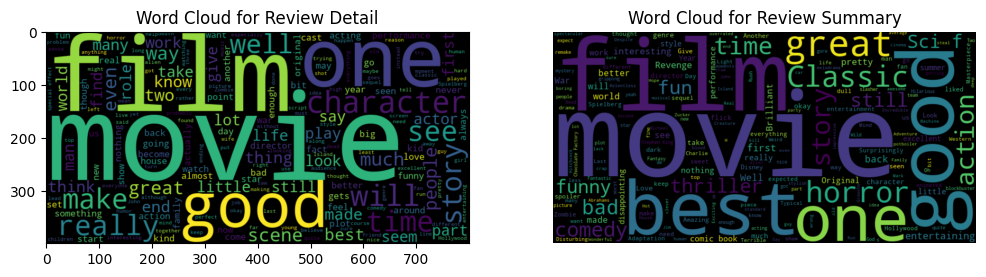

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds the can help to visualize the mose frequent words in the review_details and review_summary columns
wordcloud_detail = WordCloud(width=800, height=400).generate(' '.join(movie_reviews_df['review_detail']))
wordcloud_summary = WordCloud(width=800, height=400).generate(' '.join(movie_reviews_df['review_summary']))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_detail, interpolation='bilinear')
plt.title('Word Cloud for Review Detail')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title('Word Cloud for Review Summary')

plt.axis('off')
plt.show()

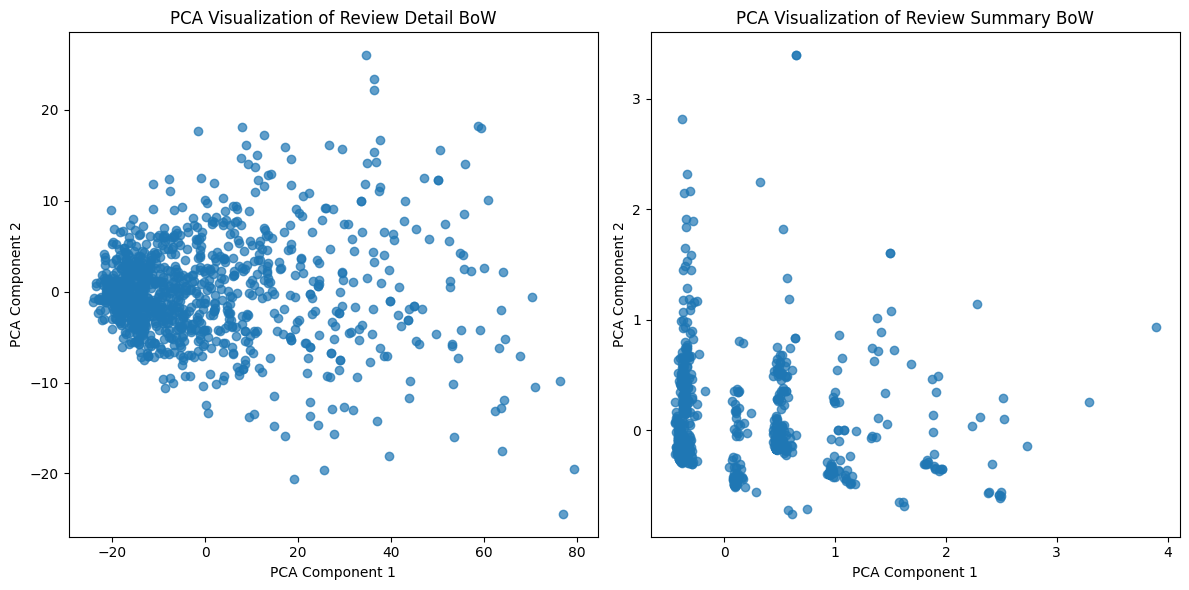

In [32]:
from textblob import TextBlob

# Add a 'sentiment' column to your DataFrame
movie_reviews_df['sentiment'] = movie_reviews_df['review_detail'].apply(lambda x: TextBlob(x).sentiment.polarity)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a CountVectorizer to convert text into a BoW representation
vectorizer = CountVectorizer()

# Fit and transform the review_detail and review_summary columns
review_detail_bow = vectorizer.fit_transform(movie_reviews_df['review_detail'])
review_summary_bow = vectorizer.fit_transform(movie_reviews_df['review_summary'])

# Perform PCA on the BoW representations
pca = PCA(n_components=2)
review_detail_pca = pca.fit_transform(review_detail_bow.toarray())
review_summary_pca = pca.fit_transform(review_summary_bow.toarray())

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(review_detail_pca[:, 0], review_detail_pca[:, 1], alpha=0.7)
plt.title('PCA Visualization of Review Detail BoW')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(review_summary_pca[:, 0], review_summary_pca[:, 1], alpha=0.7)
plt.title('PCA Visualization of Review Summary BoW')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

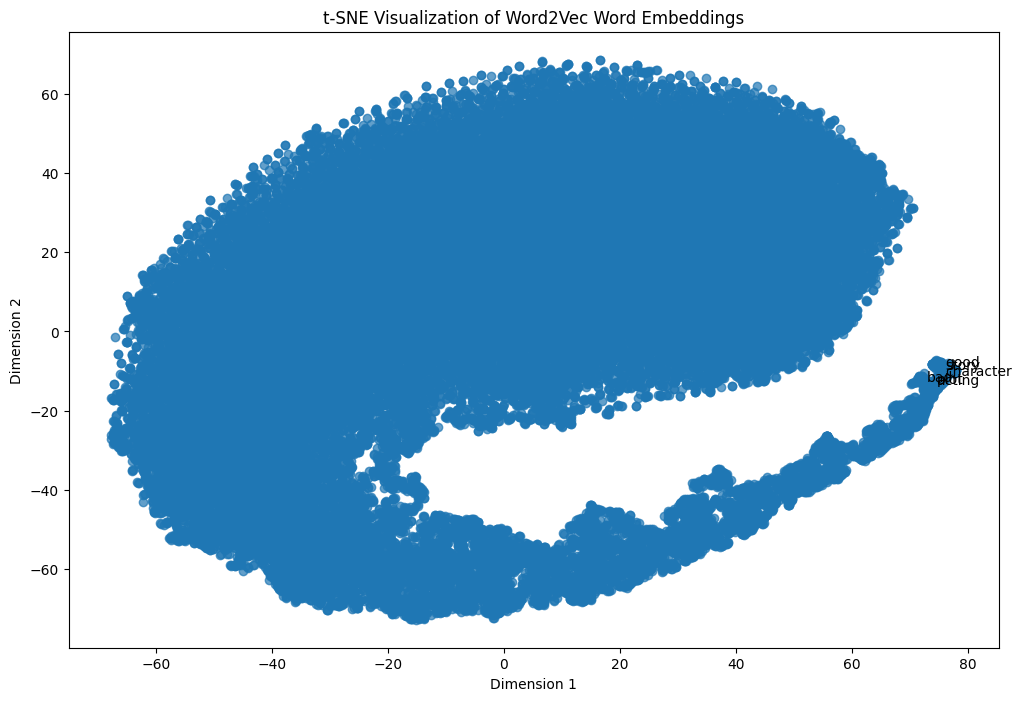

In [33]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# Tokenize the text data (assuming you've already cleaned and preprocessed the text)
tokenized_text = movie_reviews_df['review_detail'].apply(lambda x: x.split())

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)  # Adjust parameters as needed

# Get word vectors
word_vectors = model.wv

# Visualize similar words using t-SNE
from sklearn.manifold import TSNE

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors.vectors)

# Visualize the results
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# Add labels to some words for illustration (you can customize this part)
words_to_label = ['good', 'bad', 'plot', 'acting', 'story', 'character']
for word in words_to_label:
    idx = word_vectors.key_to_index.get(word)
    if idx is not None:
        plt.annotate(word, (word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]))

plt.title('t-SNE Visualization of Word2Vec Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


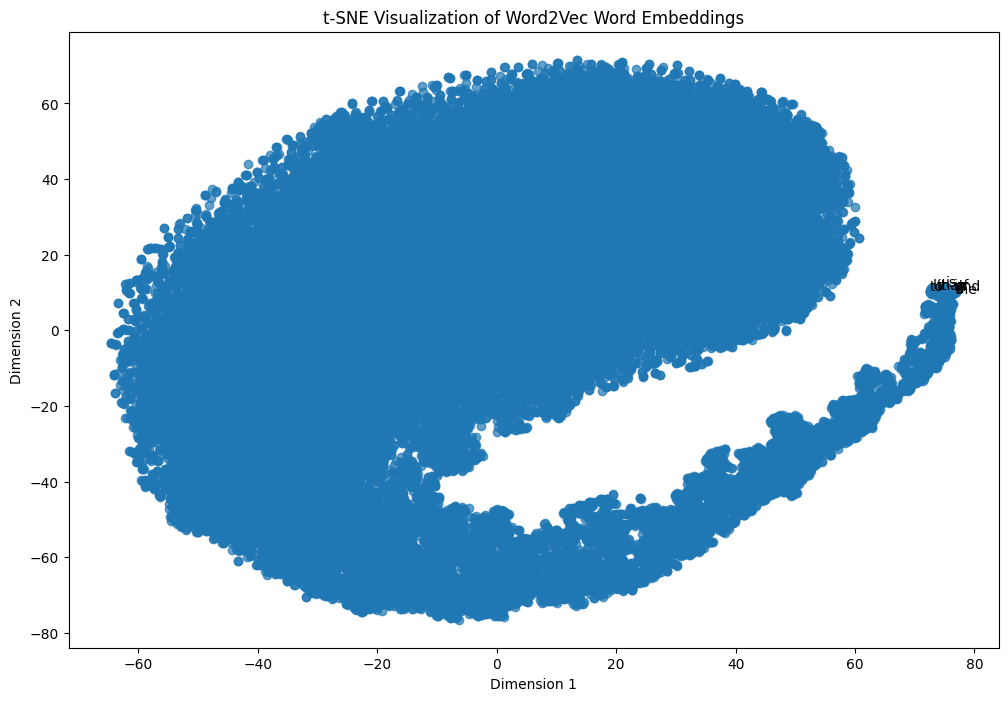

In [34]:
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize the text data (assuming you've already cleaned and preprocessed the text)
tokenized_text = movie_reviews_df['review_detail'].apply(lambda x: x.split())

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)  # Adjust parameters as needed

# Get word vectors
word_vectors = model.wv

# Extract the most common words from the text data
word_counts = Counter([word for words in tokenized_text for word in words])
most_common_words = [word for word, count in word_counts.most_common(10)]  # Adjust the number as needed

# Reduce dimensionality with t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors.vectors)

# Visualize the results
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# Add labels to the most common words for illustration
for word in most_common_words:
    idx = word_vectors.key_to_index.get(word)
    if idx is not None:
        plt.annotate(word, (word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]))

plt.title('t-SNE Visualization of Word2Vec Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


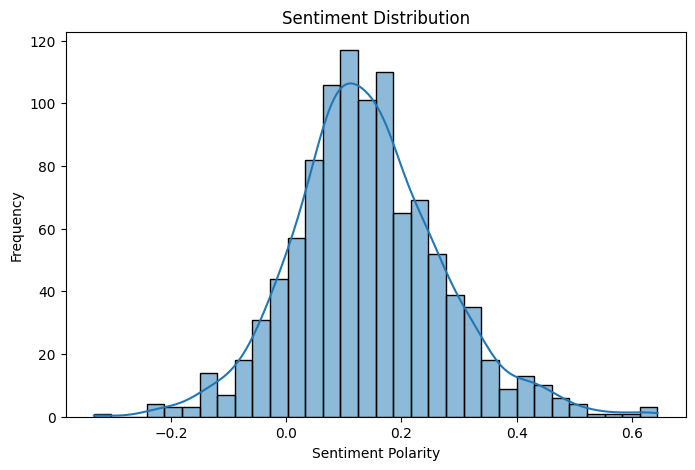

In [35]:
from textblob import TextBlob

# Sentiment analysis using TextBlob
movie_reviews_df['sentiment'] = movie_reviews_df['review_detail'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.histplot(movie_reviews_df['sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


## Model Creation

## Model Evaluation

## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/